In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy import stats
from patsy import dmatrices

import matplotlib.pyplot as plt

# Problem współliniowości

### Diagnostyka

1. **Macierz korelacji predyktorów** - $D_X = (\rho_{ij})$;

2. **Uwarunkowanie macierzy** $\frac{\lambda_{\text{max}}(D_X)}{\lambda_{\text{min}}(D_X)}$ - duże $\implies$ istnieje para predyktorów zależnych liniowo;

3. **VIF** (ang. *variance inflation factor*) - współczynnik podbicia wariancji

    Dla $1\leq i \leq p-1$: $$R^2_i = \frac{\text{RSS}}{\text{TSS}}$$ dla modelu $x_i \sim x_{-i}$, gdzie $x_{-i}$ oznacza wszystkie zmienne objaśniające z  pominięciem $i$-tej.

    Wówczas
    $$
    \text{VIF}_i = \frac{1}{1-R_i^2}
    $$

    **Interpretacja:** Duża wartość dla pewnego $i$ wskazuje na potencjalną liniową zależność $i$-tej zmiennej objaśniającej od pozostałych zmiennych. 

    **Reguła kciuka:** Jeśli $\text{VIF}_i\geq 10$, to $i$-tą zmienną uznajemy w przybliżeniu liniowo zależną od pozostałych.

# Zadanie 1
Dla danych `Carseats` sprawdź, czy występuje w nich problem współliniowości przy użyciu powyższych metod. Jeśli tak, odrzuć ze zbioru zmienne zależne liniowo i dopasuj model regresji liniowej bez nich. Porównaj wyniki.

In [2]:
carseats = sm.datasets.get_rdataset(dataname="Carseats", package="ISLR", cache=True)

In [3]:
#X ma być bez Sales
Xvar = carseats.data.loc[:, ~carseats.data.columns.isin(['Sales'])]
features = Xvar.columns[[0,1,2,3,4,6,7]] #tylko ciągłe

correlation_matrix = Xvar.corr()
print(correlation_matrix)

             CompPrice    Income  Advertising  Population     Price       Age  \
CompPrice     1.000000 -0.080653    -0.024199   -0.094707  0.584848 -0.100239   
Income       -0.080653  1.000000     0.058995   -0.007877 -0.056698 -0.004670   
Advertising  -0.024199  0.058995     1.000000    0.265652  0.044537 -0.004557   
Population   -0.094707 -0.007877     0.265652    1.000000 -0.012144 -0.042663   
Price         0.584848 -0.056698     0.044537   -0.012144  1.000000 -0.102177   
Age          -0.100239 -0.004670    -0.004557   -0.042663 -0.102177  1.000000   
Education     0.025197 -0.056855    -0.033594   -0.106378  0.011747  0.006488   

             Education  
CompPrice     0.025197  
Income       -0.056855  
Advertising  -0.033594  
Population   -0.106378  
Price         0.011747  
Age           0.006488  
Education     1.000000  


<ipython-input-3-898122950180>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = Xvar.corr()


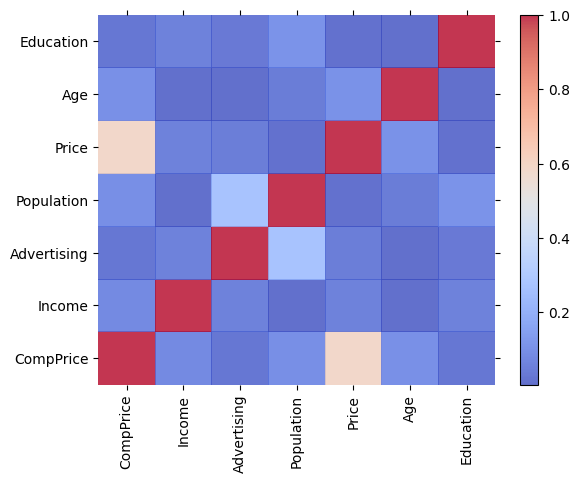

In [4]:
#zrobimy heatmapę od wartości bezwzględnych 0 - brak koralcji,  1-mocna korelacja
import matplotlib as mpl
heatmap = plt.pcolor(np.abs(correlation_matrix), cmap=mpl.cm.coolwarm, alpha=0.8)

heatmap.axes.set_frame_on(False)
heatmap.axes.set_yticks(np.arange(correlation_matrix.shape[0]) + 0.5, minor=False)
heatmap.axes.set_xticks(np.arange(correlation_matrix.shape[1]) + 0.5, minor=False)
heatmap.axes.set_xticklabels(features, minor=False)
plt.xticks(rotation=90)
heatmap.axes.set_yticklabels(features, minor=False)
plt.tick_params(axis='both', which='both', bottom='off', 
                    top='off', left='off', right='off')
plt.colorbar()
plt.show()

In [5]:
#Vify
from statsmodels.stats.outliers_influence import variance_inflation_factor
columns = list(carseats.data.columns)
columns.remove('Sales')
features = "+".join(columns)
y, X = dmatrices('Sales ~ ' + features+"-1", data=carseats.data, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif #tu dla wszystkich zmiennych jest ok

,VIF Factor,features
0,33.671155,ShelveLoc[Bad]
1,29.863368,ShelveLoc[Good]
2,75.283908,ShelveLoc[Medium]
3,1.022705,Urban[T.Yes]
4,1.980720,US[T.Yes]
5,1.554618,CompPrice
6,1.024731,Income
7,2.103136,Advertising
8,1.145534,Population
9,1.537068,Price


# Zadanie 2
Wczytaj dane `kc_house_data.csv` ([This dataset contains house sale prices for King County, which includes Seattle. It includes homes sold between May 2014 and May 2015](https://www.kaggle.com/harlfoxem/housesalesprediction/data)).

Dopasuj model `price ~ bathrooms + sqft_living + sqft_lot + sqft_above + sqft_basement + lat + long`, uwzględnij współliniowość predyktorów.

In [ ]:
house = pd.read_csv('kc_house_data.csv')
house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
columns = np.array(['bathrooms', 'sqft_living', 'sqft_lot',
                    'sqft_above', 'sqft_basement', 'lat', 'long'])
lm = smf.ols('price~bathrooms+sqft_living+sqft_lot+sqft_above+sqft_basement+lat+long'
,data = house).fit()

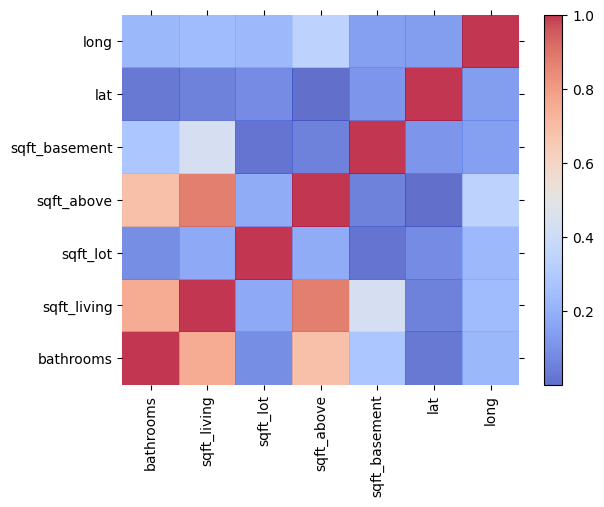

In [ ]:
#heatmapa od wartości bezwzględnych korelacji - im bliżej 1 tym większe skorelowanie
correlation_matrix = house[columns].corr()
heatmap = plt.pcolor(np.abs(correlation_matrix),alpha =0.8,cmap=mpl.cm.coolwarm)
heatmap.axes.set_frame_on(False)
heatmap.axes.set_yticks(np.arange(correlation_matrix.shape[0]) + 0.5, minor=False)
heatmap.axes.set_xticks(np.arange(correlation_matrix.shape[1]) + 0.5, minor=False)
heatmap.axes.set_xticklabels(columns, minor=False)
plt.xticks(rotation=90)
heatmap.axes.set_yticklabels(columns, minor=False)
plt.tick_params(axis='both', which='both', bottom='off', 
                    top='off', left='off', right='off')
plt.colorbar()
plt.show()



In [ ]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     4975.
Date:                Sun, 21 May 2023   Prob (F-statistic):               0.00
Time:                        23:14:19   Log-Likelihood:            -2.9823e+05
No. Observations:               21613   AIC:                         5.965e+05
Df Residuals:                   21606   BIC:                         5.965e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -7.405e+07   1.59e+06    -46.635      0.000   -7.72e+07   -7.09e+07
bathrooms      3735.1592   3226.507      1.158      0.247   -2589.033    1.01e+04
sqft_living     182.5484      1.942     94.000      0.000     178.742     186.355
sqft_lot          0.1366      0.041      3.356      0.001       0.057       0.216
sqft_above      109.3906      2.015     54.299      0.000     105.442     113.339
sqft_basement    73.1581      2.620     27.919      0.000      68.022      78.294
lat            6.806e+05   1.19e+04     57.279      0.000    6.57e+05    7.04e+05
long          -3.405e+05   1.27e+04    -26.857      0.000   -3.65e+05   -3.16e+05
==============================================================================
Omnibus:                    16869.253   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           923207.453
Skew:                           3.300   Prob(JB):                         0.00
Kurtosis:                      34.331   Cond. No.                     1.61e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.62e-21. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] =[variance_inflation_factor(house[columns].values,i) for i in range(len(columns))]
vif["features"] = columns
vif

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,2.005042e+01,bathrooms
1,inf,sqft_living
2,1.179803e+00,sqft_lot
3,inf,sqft_above
4,inf,sqft_basement
5,1.147556e+05,lat
6,1.145354e+05,long


In [ ]:
#sqft_living = sqft_above+sqft_basement - idealna współliniowość - usuwamy sqft_living
columns2 = np.array(['bathrooms', 'sqft_lot',
                    'sqft_above', 'sqft_basement', 'lat', 'long'])
lm2 = smf.ols('price~bathrooms+sqft_lot+sqft_above+sqft_basement+lat+long'
,data = house).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     4975.
Date:                Sun, 21 May 2023   Prob (F-statistic):               0.00
Time:                        23:14:26   Log-Likelihood:            -2.9823e+05
No. Observations:               21613   AIC:                         5.965e+05
Df Residuals:                   21606   BIC:                         5.965e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -7.405e+07   1.59e+06    -46.635      0.000   -7.72e+07   -7.09e+07
bathrooms      3735.1592   3226.507      1.158      0.247   -2589.033    1.01e+04
sqft_lot          0.1366      0.041      3.356      0.001       0.057       0.216
sqft_above      291.9390      2.965     98.447      0.000     286.126     297.751
sqft_basement   255.7065      4.149     61.627      0.000     247.574     263.839
lat            6.806e+05   1.19e+04     57.279      0.000    6.57e+05    7.04e+05
long          -3.405e+05   1.27e+04    -26.857      0.000   -3.65e+05   -3.16e+05
==============================================================================
Omnibus:                    16869.253   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           923207.453
Skew:                           3.300   Prob(JB):                         0.00
Kurtosis:                      34.331   Cond. No.                     4.33e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.33e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] =[variance_inflation_factor(house[columns2].values,i) for i in range(len(columns2))]
vif["features"] = columns2
vif #wyrzucany lat

,VIF Factor,features
0,20.050421,bathrooms
1,1.179803,sqft_lot
2,12.710522,sqft_above
3,1.791748,sqft_basement
4,114755.626015,lat
5,114535.443497,long


In [ ]:
columns3 = np.array(['bathrooms', 'sqft_lot',
                    'sqft_above', 'sqft_basement', 'long'])
lm3 = smf.ols('price~bathrooms+sqft_lot+sqft_above+sqft_basement+long'
,data = house).fit()
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     4614.
Date:                Sun, 21 May 2023   Prob (F-statistic):               0.00
Time:                        23:14:31   Log-Likelihood:            -2.9975e+05
No. Observations:               21613   AIC:                         5.995e+05
Df Residuals:                   21607   BIC:                         5.996e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -5.196e+07   1.65e+06    -31.431      0.000   -5.52e+07   -4.87e+07
bathrooms       881.4780   3462.329      0.255      0.799   -5904.943    7667.899
sqft_lot         -0.0240      0.044     -0.550      0.582      -0.109       0.061
sqft_above      300.6646      3.178     94.598      0.000     294.435     306.894
sqft_basement   277.8804      4.434     62.675      0.000     269.190     286.571
long          -4.245e+05   1.35e+04    -31.408      0.000   -4.51e+05   -3.98e+05
==============================================================================
Omnibus:                    14211.786   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           513412.003
Skew:                           2.652   Prob(JB):                         0.00
Kurtosis:                      26.281   Cond. No.                     4.20e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.2e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] =[variance_inflation_factor(house[columns3].values,i) for i in range(len(columns3))]
vif["features"] = columns3
vif #tym razem bathroomsy

,VIF Factor,features
0,20.050421,bathrooms
1,1.179267,sqft_lot
2,12.598219,sqft_above
3,1.786517,sqft_basement
4,8.674776,long


In [ ]:
columns4 = np.array(['sqft_lot',
                    'sqft_above', 'sqft_basement', 'long'])
lm4 = smf.ols('price~sqft_lot+sqft_above+sqft_basement+long'
,data = house).fit()
lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     5768.
Date:                Sun, 21 May 2023   Prob (F-statistic):               0.00
Time:                        23:14:35   Log-Likelihood:            -2.9975e+05
No. Observations:               21613   AIC:                         5.995e+05
Df Residuals:                   21608   BIC:                         5.996e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -5.193e+07   1.65e+06    -31.476      0.000   -5.52e+07   -4.87e+07
sqft_lot         -0.0249      0.043     -0.573      0.567      -0.110       0.060
sqft_above      301.2365      2.248    133.975      0.000     296.829     305.644
sqft_basement   278.3821      3.971     70.096      0.000     270.598     286.166
long          -4.243e+05   1.35e+04    -31.451      0.000   -4.51e+05   -3.98e+05
==============================================================================
Omnibus:                    14208.662   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           513034.687
Skew:                           2.651   Prob(JB):                         0.00
Kurtosis:                      26.272   Cond. No.                     4.19e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.19e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] =[variance_inflation_factor(house[columns4].values,i) for i in range(len(columns4))]
vif["features"] = columns4
vif #jest ok

,VIF Factor,features
0,1.173289,sqft_lot
1,5.871162,sqft_above
2,1.438995,sqft_basement
3,6.253636,long


# Zadanie 3
Wczytaj zbiór `Hald.csv`. Znajdź najlepszy model regresji liniowej uwzględniając współliniowość predyktorów.

Opis zbioru:

    Heat evolved during setting of 13 cement mixtures of four basic ingredients. Each ingredient percentage appears to be rounded down to a full integer. The sum of the four mixture percentages varies from a maximum of 99% to a minimum of 95%. If all four regressor X-variables always summed to 100%, the centered X-matrix would then be of rank only 3. Thus, the regression of heat on four X-percentages is ill-conditioned, with an approximate rank deficiency of MCAL = 1. The first column is the response and the remaining four columns are the predictors.

In [ ]:
hald = pd.read_csv("Hald.csv")
hald.head()

,y,X1,X2,X3,X4
0,78.5,7,26,6,60
1,74.3,1,29,15,52
2,104.3,11,56,8,20
3,87.6,11,31,8,47
4,95.9,7,52,6,33


In [ ]:
y, X = dmatrices('y ~ X1 + X2 + X3 + X4', data=hald, return_type='dataframe')

In [ ]:
model3 = sm.OLS(endog=y, exog=X)
fitted_model3 = model3.fit()
fitted_model3.summary()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     111.5
Date:                Sun, 21 May 2023   Prob (F-statistic):           4.76e-07
Time:                        23:14:57   Log-Likelihood:                -26.918
No. Observations:                  13   AIC:                             63.84
Df Residuals:                       8   BIC:                             66.66
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     62.4054     70.071      0.891      0.399     -99.179     223.989
X1             1.5511      0.745      2.083      0.071      -0.166       3.269
X2             0.5102      0.724      0.705      0.501      -1.159       2.179
X3             0.1019      0.755      0.135      0.896      -1.638       1.842
X4            -0.1441      0.709     -0.203      0.844      -1.779       1.491
==============================================================================
Omnibus:                        0.165   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.921   Jarque-Bera (JB):                0.320
Skew:                           0.201   Prob(JB):                        0.852
Kurtosis:                       2.345   Cond. No.                     6.06e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
X.values

array([[ 1.,  7., 26.,  6., 60.],
       [ 1.,  1., 29., 15., 52.],
       [ 1., 11., 56.,  8., 20.],
       [ 1., 11., 31.,  8., 47.],
       [ 1.,  7., 52.,  6., 33.],
       [ 1., 11., 55.,  9., 22.],
       [ 1.,  3., 71., 17.,  6.],
       [ 1.,  1., 31., 22., 44.],
       [ 1.,  2., 54., 18., 22.],
       [ 1., 21., 47.,  4., 26.],
       [ 1.,  1., 40., 23., 34.],
       [ 1., 11., 66.,  9., 12.],
       [ 1., 10., 68.,  8., 12.]])

In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values[:,1:], i) for i in range(X.shape[1]-1)]
vif["features"] = X.columns[1:] #nie liczymy vifa dla interceptow
vif #usuwamy druga

,VIF Factor,features
0,6.688643,X1
1,12.995434,X2
2,9.981159,X3
3,4.418264,X4


In [ ]:
model4 = smf.ols('y ~ X1 + X3 + X4', data=hald)

fitted_model4 = model4.fit()
fitted_model4.summary()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     157.3
Date:                Sun, 21 May 2023   Prob (F-statistic):           4.31e-08
Time:                        23:15:05   Log-Likelihood:                -27.310
No. Observations:                  13   AIC:                             62.62
Df Residuals:                       9   BIC:                             64.88
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    111.6844      4.562     24.479      0.000     101.363     122.005
X1             1.0519      0.224      4.702      0.001       0.546       1.558
X3            -0.4100      0.199     -2.058      0.070      -0.861       0.041
X4            -0.6428      0.045    -14.431      0.000      -0.744      -0.542
==============================================================================
Omnibus:                        0.353   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.838   Jarque-Bera (JB):                0.468
Skew:                           0.064   Prob(JB):                        0.791
Kurtosis:                       2.080   Cond. No.                         251.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
y, X = dmatrices('y ~ X1 + X3 + X4', data=hald, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values[:,1:], i) for i in range(X.shape[1]-1)]
vif["features"] = X.columns[1:]
vif #jest już ok

,VIF Factor,features
0,1.670660,X1
1,2.638406,X3
2,3.402385,X4


# Obserwacje odstające

### Diagnostyka

Obserwacja odstająca (ang.outlier) jest obserwacją, która nie spełnia równania regresji czyli nie należy do modelu regresji. Obserwacje odstające mogą znacząco wpływać na postać prostej regresji.

**Rezyduum** $e_i$ przyjmuje dla $i$-tej obserwacji wartość różnicy:
$$
e_i = y_i - \hat{y}_i.
$$

**Błąd standardowy** takiego rezyduum $e_i$ jest równy:
$$
\text{SE}(e_i) = S\cdot\sqrt{1-h_i},
$$
gdzie 
- $S = \sigma$ oznacza przęciętne odchylenie wartości rzeczywistych od wartości przewidywanych,
- $h_i$ - wartość wpływu $i$-tej obserwacji, która wyraża się wzorem
$$
h_i = \frac{1}{n} + \frac{(x_i - \overline{x})^2}{\sum_{i=1}^n(x_i - \overline{x})^2}
$$

Obserwacje odstajacę dzielimy na 
    - wpływowe - obserwacja jest wpływowa jesli jej usuniecie z modelu ma duży wpływ na dopasowanie modelu/prognoże na podstawie modelu;
    - niewpływowe - obserwacja jest niewpływowa jesli jej usuniecie z modelu nie ma wpływu na dopasowanie modelu/prognoże na podstawie modelu;
  

  
### Detekcja obserwacji odstających:

1. **Wykres studentyzowanych rezyduów**

Dla małych prób, wartości zmiennej objaśniającej nie są w miarę równomiernie rozłożone i niektóre błędy $\text{SE}(e_i)$ mogą znacznie odbierać od błędu $S$. Wówczas dobrze jest analizować rezydua przy użyciu tzw. **rezyduów studentyzowanych**.

$$r_i =\frac{e_i}{\text{SE}(e_i)}$$

To pozwoli wykrywać obserwacje faktycznie odstające, pomijając te, które przy analizie rezyduów $e_i$ sugerowały, że są odstające mimo, że takimi nie były. Dla rezyduów studentyzowanych zakłada się, że przy poziomie ufności równym 0.95 uznaje się je za normalne (zachowujące własność rozkładu normalnego), gdy należą do przedziału $[−2,+2]$.

Wykres studentyzowanych rezyduów względem ich indeksu identyfikuje duże wartości, które przypuszczalnie odpowiadają obserwacjom odstającym. Metodata nie sprawdzi się w sytuacji, gdy mamy w analizowanym zbiorze obserwację wpływową o małej wartości $e_i$. Wówczas bowiem nie określimy jej jako odstającej mimo, że taka w istocie jest.

2. **Wpływowość**

Wpływ $i$-tej obserwacji $h_i$ określamy wzorem
$$
h_i = \frac{1}{n} + \frac{(x_i - \overline{x})^2}{\sum_{i=1}^n(x_i - \overline{x})^2},
$$ 
który określa odstępstwo $x_i$ od $\overline{x}$.

Dla modelu o $p$ parametrach (gdzie $p$ to łączna liczba zmiennych objaśniających i objaśnianych), obserwację uznajemy za wpływową jeśli 
$$
h_i \geq \frac{2p}{n}.
$$

3. **Odległość Cooka**

Jest to miara stopnia zmiany współczynników regresji, gdyby dany przypadek pominąć w obliczeniach współczynników:
$$
D_i = \frac{\sum_{j=1}^n(\hat{Y}_j - \hat{Y}_{j(i)})^2}{pS^2},
$$
gdzie $\hat{Y}_j$ - prognoza na podstawie pełnych danych, $\hat{Y}_{j(i)}$ - prognoza bez $i$-tej obserwacji.

**Interpretacja**: Duża wartość $D_i$ wskazuje na znaczy wpływ usunięcia $i$-tej obserwacji, czyli $i$-ta obserwacja jest obserwacją wpływową.

Wszystkie wartości dla danej odległości powinny być tego samego rzędu. Jeśli tak nie jest, to prawdopodobnie dany przypadek ma istotnie duży wpływ na obciążenie równania regresji.

**Reguła kciuka**: $D_i > \frac{4}{(n − p − 1)}$

# Zadanie 4
Przeanalizuj obserwacje odstające w modelu `model` dla danych `Carseats`. Zidentyfikuj obserwacje im odpowiadające, usuń je ze zbioru i zbuduj model ponownie. Porównaj dopasowanie modeli. 
Analogicznie postępuj dla modelu `model2`.

In [ ]:
carseats = sm.datasets.get_rdataset(dataname="Carseats", package="ISLR", cache=True)
columns = list(carseats.data.columns)
columns.remove('Sales')
features = "+".join(columns)

model = smf.ols('Sales ~ ' + features, data=carseats.data)
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     243.4
Date:                Sun, 21 May 2023   Prob (F-statistic):          1.60e-166
Time:                        23:15:26   Log-Likelihood:                -568.99
No. Observations:                 400   AIC:                             1162.
Df Residuals:                     388   BIC:                             1210.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.6606      0.603      9.380      0.000       4.474       6.847
ShelveLoc[T.Good]       4.8502      0.153     31.678      0.000       4.549       5.151
ShelveLoc[T.Medium]     1.9567      0.126     15.516      0.000       1.709       2.205
Urban[T.Yes]            0.1229      0.113      1.088      0.277      -0.099       0.345
US[T.Yes]              -0.1841      0.150     -1.229      0.220      -0.479       0.111
CompPrice               0.0928      0.004     22.378      0.000       0.085       0.101
Income                  0.0158      0.002      8.565      0.000       0.012       0.019
Advertising             0.1231      0.011     11.066      0.000       0.101       0.145
Population              0.0002      0.000      0.561      0.575      -0.001       0.001
Price                  -0.0954      0.003    -35.700      0.000      -0.101      -0.090
Age                    -0.0460      0.003    -14.472      0.000      -0.052      -0.040
Education              -0.0211      0.020     -1.070      0.285      -0.060       0.018
==============================================================================
Omnibus:                        0.811   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.667   Jarque-Bera (JB):                0.765
Skew:                           0.107   Prob(JB):                        0.682
Kurtosis:                       2.994   Cond. No.                     4.15e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
h = fitted_model.get_influence()
h.resid_studentized


array([ 2.24252234, -1.19294915,  0.7673699 , -1.10096644, -1.92751846,
        1.1385529 ,  0.42882349,  0.3002147 ,  0.44537056, -1.12713069,
        0.87498929,  0.10864812,  0.23732197, -0.94598368,  1.5812939 ,
        2.68280493, -0.90056957,  0.46918652,  0.51731325,  0.97997718,
       -0.00947193,  1.00786336, -0.7366876 ,  0.58807835,  0.13356578,
        1.49165942, -0.17647458,  0.07418664, -1.39637616,  1.8461038 ,
       -0.14267775,  0.03222147,  0.13257894,  0.31652513, -2.00089648,
        0.32832437, -1.51799084, -1.98425367,  0.51658082, -0.34468259,
       -0.45424237,  1.51543928, -0.5904213 , -1.096305  , -0.82713855,
       -0.00433115, -0.73024826, -1.50174549, -0.62928836, -0.03555808,
       -1.84576605,  0.04180425,  1.56194506,  1.13544465, -0.61468275,
        1.97628987,  1.18367665, -0.10643179,  0.47043461, -0.29643053,
        0.68545345,  1.04887437, -0.83534378, -0.07289291,  0.23833471,
        0.51605326, -0.60087042,  0.50216278,  1.29443813,  0.14

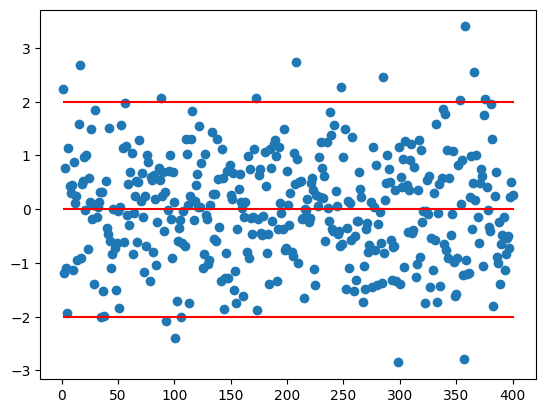

In [ ]:
#wartości odstające
x = np.arange(1, h.resid_studentized.size + 1)
plt.scatter(x=x, y=h.resid_studentized)
plt.hlines(xmin=1, xmax=h.resid_studentized.size + 1, y=-2, color="r")
plt.hlines(xmin=1, xmax=h.resid_studentized.size + 1, y=0, color="r")
plt.hlines(xmin=1, xmax=h.resid_studentized.size + 1, y=2, color="r")
#te poza pasem kwalifikujemy jako do usunięcia

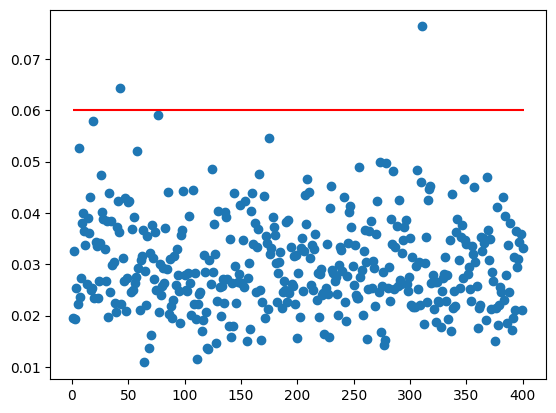

In [ ]:
#wartości wpływowe h_i
h.hat_matrix_diag
threshold = 2*h.exog.shape[1]/h.exog.shape[0]

x = np.arange(1, h.hat_matrix_diag.size + 1)
plt.scatter(x=x, y=h.hat_matrix_diag)
plt.hlines(xmin=1, xmax=h.hat_matrix_diag.size + 1, y=threshold, color="r")
#są dwie obs wpływowe

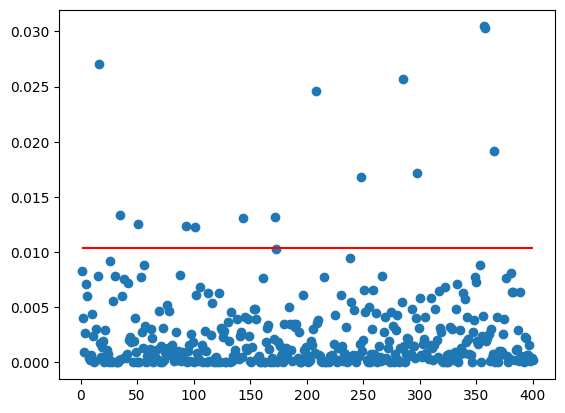

In [ ]:
#obserwacje wpływowe odległości cooka (inna metoda detekcji wpływowości)
threshold = 4/(h.exog.shape[0]-h.exog.shape[1]-1)
h.cooks_distance
x = np.arange(1, h.cooks_distance[0].size + 1)
plt.scatter(x=x, y=h.cooks_distance[0])
plt.hlines(xmin=1, xmax = x[-1], y = threshold, color='r')
